# Code for generating Figure 2

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

### Define Functions

In [2]:
def unit_vec(d):
    v = np.random.randn(d,1)
    return v/la.norm(v)

def orth_vect(v, w):
    return v-(v.T@w)*w

def dist(v, w):
    return 1-(v.T@w)**2/(v.T@v)/(w.T@w)

def orthomatrix(d, k):
    x = np.random.randn(d,k)
    x,_ = la.qr(x, mode='economic')
    return x

def twoDcca_SVD(X, Y, k1, k2, loading_true, loading_init=None, regular=1e-6, iter_max=10):
    (T, mx, nx) = X.shape
    (T, my, ny) = Y.shape

    corr = np.zeros(iter_max+1)
    error = np.zeros(iter_max+1)
    error_Lx = np.zeros(iter_max+1)
    error_Rx = np.zeros(iter_max+1)
    error_Ly = np.zeros(iter_max+1)
    error_Ry = np.zeros(iter_max+1)
    
    U1 = loading_true[0]
    U2 = loading_true[1]
    V1 = loading_true[2]
    V2 = loading_true[3]
    
    (Lx, Rx, Ly, Ry) = loading_init if loading_init else list(map(lambda x: np.random.randn(x, 1), (mx, nx, my, ny)))
    X_tf = towDcca_transform(X, Lx, Rx)
    Y_tf = towDcca_transform(Y, Ly, Ry)
    corr[0] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
    
    (error_Lx[0], error_Rx[0], error_Ly[0], error_Ry[0])  = list(map(dist, (Lx, Rx, Ly, Ry), (U1, U2, V1, V2)))
    
    for i in range(iter_max):
        diff = 0
        # estimate Lx, Ly
        XR = np.matmul(X, Rx)
        YR = np.matmul(Y, Ry)
        Srxx = np.matmul(XR, XR.transpose(0,2,1)).sum(axis=0)/T
        Srxy = np.matmul(XR, YR.transpose(0,2,1)).sum(axis=0)/T
        Sryy = np.matmul(YR, YR.transpose(0,2,1)).sum(axis=0)/T
        A = np.block([[np.zeros((mx, mx)), Srxy], [Srxy.T, np.zeros((my, my))]])
        B = la.block_diag(Srxx, Sryy)+regular*np.eye(mx+my)
        (Leval, Levec) = la.eigh(A, b=B)
        diff += la.norm(Lx-Levec[:mx, :k1])
        Lx = Levec[:mx, :k1]
        diff += la.norm(Ly-Levec[mx:, :k1])
        Ly = Levec[mx:, :k1]

        # estimate Rx, Ry
        XL = np.matmul(X.transpose(0,2,1), Lx)
        YL = np.matmul(Y.transpose(0,2,1), Ly)
        Slxx = np.matmul(XL, XL.transpose(0,2,1)).sum(axis=0)/T
        Slxy = np.matmul(XL, YL.transpose(0,2,1)).sum(axis=0)/T
        Slyy = np.matmul(YL, YL.transpose(0,2,1)).sum(axis=0)/T
        A = np.block([[np.zeros((nx, nx)), Slxy], [Slxy.T, np.zeros((ny, ny))]])
        B = la.block_diag(Slxx, Slyy)+regular*np.eye(nx+ny)
        (Reval, Revec) = la.eigh(A, b=B)
        diff += la.norm(Rx-Revec[:nx, :k2])
        Rx = Revec[:nx, :k2]
        diff += la.norm(Ry-Revec[nx:, :k2])
        Ry = Revec[nx:, :k2]
        
        X_tf = towDcca_transform(X, -Lx, Rx)
        Y_tf = towDcca_transform(Y, Ly, Ry)
        corr[i+1] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
        (error_Lx[i+1], error_Rx[i+1], error_Ly[i+1], error_Ry[i+1])  = list(map(dist, (Lx, Rx, Ly, Ry), (U1, U2, V1, V2)))
    
    error = error_Lx+error_Rx+error_Ly+error_Ry
        
    return (Lx, Rx, Ly, Ry), corr, error

def towDcca_transform(X, L, R):
    (N, _, _) = X.shape
    (_, k1) = L.shape
    (_, k2) = R.shape
    return (np.matmul(np.matmul(L.T, X), R)).reshape(N, k1*k2)

def _twoDcca_oneStep(ui, vi, X, Y, method, x_regular, y_regular):
    (N, p) = X.shape
    (N, q) = Y.shape

    Sxx = np.matmul(X.T, X)/N
    Sxy = np.matmul(X.T, Y)/N
    Syy = np.matmul(Y.T, Y)/N
    
    if method=='pi':
        u = la.solve((Sxx+x_regular*np.eye(p)),Sxy@vi)
        u /= np.sqrt(u.T@Sxx@u)
        du = u-ui
        v = la.solve((Syy+y_regular*np.eye(q)),Sxy.T@u)
        v /= np.sqrt(v.T@Syy@v)
        dv = v-vi
    if method=='als':
        u = la.solve((Sxx+x_regular*np.eye(p)),Sxy@vi)
        u /= la.norm(u)
        du = u-ui
        v = la.solve((Syy+y_regular*np.eye(q)),Sxy.T@u)
        v /= la.norm(v)
        dv = v-vi

    return u, v, du.T@du, dv.T@dv

def twoDcca(X, Y, loading_true, method='als', loading_init=None, x_regular=1e-8, y_regular=1e-8, iter_max=10):
    (N, mx, nx) = X.shape
    (_, my, ny) = Y.shape
    
    (Lx, Rx, Ly, Ry) = loading_init if loading_init else list(map(unit_vec, (mx, nx, my, ny)))
    
    if loading_true is None:
        loading_true = (Lx, Rx, Ly, Ry)
    
    loading = [Lx, Rx, Ly, Ry]
    
    corr = np.zeros(iter_max+1)
    error = np.zeros(iter_max+1)
    error_Lx = np.zeros(iter_max+1)
    error_Rx = np.zeros(iter_max+1)
    error_Ly = np.zeros(iter_max+1)
    error_Ry = np.zeros(iter_max+1)
    
    X_tf = towDcca_transform(X, Lx, Rx)
    Y_tf = towDcca_transform(Y, Ly, Ry)
    corr[0] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
    
    (error_Lx[0], error_Rx[0], error_Ly[0], error_Ry[0])  = list(map(dist, (Lx, Rx, Ly, Ry), loading_true))
    
    for n in range(iter_max):
        
        XR = np.matmul(X, Rx)[:,:,0]
        YR = np.matmul(Y, Ry)[:,:,0]
        (Lx, Ly, dLx, dLy) = _twoDcca_oneStep(Lx, Ly, XR, YR, method, x_regular, y_regular)
        XL = np.matmul(X.transpose(0,2,1), Lx)[:,:,0]
        YL = np.matmul(Y.transpose(0,2,1), Ly)[:,:,0]
        (Rx, Ry, dRx, dRy) = _twoDcca_oneStep(Rx, Ry, XL, YL, method, x_regular, y_regular)
            
        
        X_tf = towDcca_transform(X, Lx, Rx)
        Y_tf = towDcca_transform(Y, Ly, Ry)
      
        loading = [Lx, Rx, Ly, Ry]
        corr[n+1] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
        
        (error_Lx[n+1], error_Rx[n+1], error_Ly[n+1], error_Ry[n+1])  = list(map(dist, (Lx, Rx, Ly, Ry), loading_true))
    
    error = error_Lx+error_Rx+error_Ly+error_Ry
        
    return loading, corr, error

def genData_pCCA(T, mx, nx, my, ny, k, e):
    X2d = np.zeros((T, mx, nx))
    Y2d = np.zeros((T, my, ny))
    U1 = orthomatrix(mx, k)
    U2 = orthomatrix(nx, k)
    V1 = orthomatrix(my, k)
    V2 = orthomatrix(ny, k)
    for t in range(T):
        Ex = np.random.randn(k,k)
        Ey = np.random.randn(k,k)
        c = np.random.randn(1)
        Ex[0,0] = np.sqrt(1-e)*c + np.sqrt(e)*Ex[0,0]
        X2d[t,:,:] = U1@Ex@U2.T
        Ey[0,0] = np.sqrt(1-e)*c + np.sqrt(e)*Ey[0,0]
        Y2d[t,:,:] = V1@Ey@V2.T
    return X2d, Y2d, U1[:,0:1], U2[:,0:1], V1[:,0:1], V2[:,0:1]

def oneDcca_ssa(X, Y, k, regular=1e-6):
    (N, p) = X.shape
    (_, q) = Y.shape

    Sxx = X.T@X/N
    Sxy = X.T@Y/N
    Syy = Y.T@Y/N
    A = np.block([[np.zeros((p, q)), Sxy], [Sxy.T, np.zeros((q, p))]])
    B = la.block_diag(Sxx, Syy)+regular*np.eye(p+q)
    (Leval, Levec) = la.eigh(A, b=B)
    Cx = Levec[:p, :k]
    Cy = Levec[p:, :k]

    return -Cx, Cy

def effectiveInit(X, Y):
    (N, mx, nx) = X.shape
    (_, my, ny) = Y.shape
    
    Xv = X.reshape(N, mx*nx, order='F')
    Yv = Y.reshape(N, my*ny, order='F')
    
    Cx, Cy = oneDcca_ssa(Xv, Yv, 1, regular=1e-6)
    
    Umat = Cx.reshape(mx, nx, order='F')
    Vmat = Cy.reshape(my, ny, order='F')
    (UL, Uval, UR) = la.svd(Umat)
    (VL, Vval, VR) = la.svd(Vmat)
    
    return (UL[:,0:1], UR[0:1,:].T, VL[:,0:1], VR[0:1,:].T)

def findOpt(M, I, X, Y):
    corrOpt = np.zeros(M)
    for m in range(M):
        (loading, corr, error) = twoDcca(X, Y, None, iter_max=I)
        corrOpt[m] = corr[-1]
    return corrOpt.max()

def dist(v, w):
    return 1-(v.T@w)**2/(v.T@v)/(w.T@w)

# Simulation

In [3]:
mx, nx, my, ny = 3, 4, 4, 3
TT = [50, 100, 300, 600, 1000]
M = 100
I = 30
e = 0.001
NN = [0.2, 0.5, 0.8]
corrOpt = np.zeros(M)

avg_attOpt_random = np.zeros((len(NN),len(TT)))
avg_error_random = np.zeros((len(NN),len(TT)))
# avg_attOpt_SVD = np.zeros((len(NN),len(TT)))
# avg_error_SVD = np.zeros((len(NN),len(TT)))
avg_attOpt_effInit = np.zeros((len(NN),len(TT)))
avg_error_effInit = np.zeros((len(NN),len(TT)))
avg_corrOpt = np.zeros((len(NN),len(TT)))

for j,n in enumerate(NN):
    print(n)
    for i,t in enumerate(TT):
        attOpt_random = np.zeros(M)
        attOpt_effInit = np.zeros(M)
#         attOpt_SVD = np.zeros(M)
        error_random = np.zeros(M)
#         error_SVD = np.zeros(M)
        error_effInit = np.zeros(M)
        for m in range(M):
            X2d, Y2d, U1, U2, V1, V2 = genData_pCCA(t, mx, nx, my, ny, 2,n)
            loading_true = [U1, U2, V1, V2]

            corrOpt[m] = findOpt(15, I, X2d, Y2d)

            loading_random = list(map(lambda x: np.random.randn(x, 1), (mx, nx, my, ny)))

            (loading, corr, error) = twoDcca(X2d, Y2d, loading_true, method='als', iter_max=I, loading_init=loading_random)
            attOpt_random[m] = True if abs(corrOpt[m]-corr[-1])<e else False
            error_random[m] = error[-1]

#             (loading, corr, error) = twoDcca_SVD(X2d, Y2d, 1, 1, loading_true, iter_max=I, loading_init=loading_random)
#             attOpt_SVD[m] = True if abs(corrOpt[m]-corr[-1])<e else False
#             error_SVD[m] = error[-1]

            effInit = effectiveInit(X2d, Y2d)
            (loading, corr, error) = twoDcca(X2d, Y2d, loading_true, method='als', iter_max=I, loading_init=effInit)
            attOpt_effInit[m] = True if abs(corrOpt[m]-corr[-1])<e else False
            error_effInit[m] = error[-1]

        avg_attOpt_random[j,i] = attOpt_random.mean()
        avg_error_random[j,i] = error_random.mean()
#         avg_attOpt_SVD[j,i] = attOpt_SVD.mean()
#         avg_error_SVD[j,i] = error_SVD.mean()
        avg_attOpt_effInit[j,i] = attOpt_effInit.mean()
        avg_error_effInit[j,i] = error_effInit.mean()
        avg_corrOpt[j,i] = corrOpt.mean()

0.2
0.5
0.8


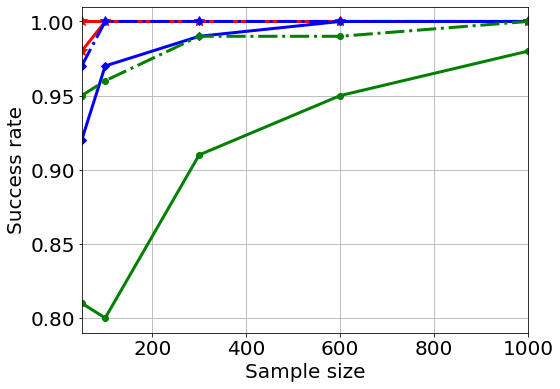

In [17]:
plt.figure(figsize=(8,6))
plt.plot(TT,avg_attOpt_random[0,:],'r.-', label="sHOPM(random), lambda=0.8", color='r', linestyle='-', marker='*', markersize=10, linewidth=3)
# plt.plot(TT,avg_attOpt_SVD[0,:], label="SVD, lambda=0.8", color='r',linestyle=':', marker='*', markersize=10)
plt.plot(TT,avg_attOpt_effInit[0,:], label="sHOPM(effective), lambda=0.8", color='r', linestyle='-.', marker='*', markersize=10, linewidth=3)

plt.plot(TT,avg_attOpt_random[1,:], label="sHOPM(random), lambda=0.5", color='b', linestyle='-', marker='D', markersize=6, linewidth=3)
# plt.plot(TT,avg_attOpt_SVD[1,:], label="SVD, lambda=0.5", color='b',linestyle=':', marker='D', markersize=6)
plt.plot(TT,avg_attOpt_effInit[1,:], label="sHOPM(effective), lambda=0.5", color='b', linestyle='-.', marker='D', markersize=6, linewidth=3)

plt.plot(TT,avg_attOpt_random[2,:], label="sHOPM(random), lambda=0.2", color='g', linestyle='-', marker='o', markersize=6, linewidth=3)
# plt.plot(TT,avg_attOpt_SVD[2,:], label="SVD, lambda=0.2", color='g',linestyle=':', marker='o', markersize=6)
plt.plot(TT,avg_attOpt_effInit[2,:], label="sHOPM(effective), lambda=0.2", color='g', linestyle='-.', marker='o', markersize=6, linewidth=3)

# plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
plt.ylabel("Success rate")
plt.xlabel("Sample size")
plt.xlim(50,1000)
plt.grid(True)
# plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
plt.savefig('WhiteningModelSucRate.png', bbox_inches='tight')
plt.show()

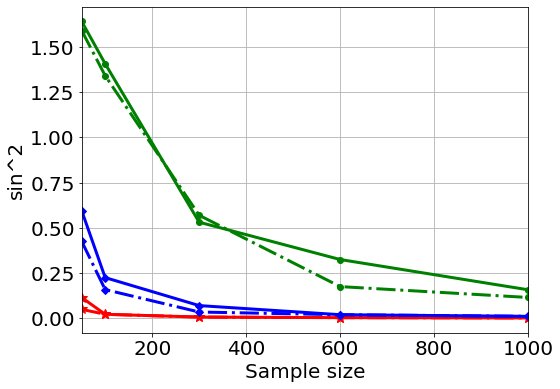

In [21]:
plt.figure(figsize=(8,6))
plt.plot(TT,avg_error_random[0,:], label="sHOPM(random), lambda=0.8", color='r', linestyle='-', marker='*', markersize=10, linewidth=3)
# plt.plot(TT,avg_error_SVD[0,:], label="SVD, lambda=0.8", color='r',linestyle=':', marker='*', markersize=10)
plt.plot(TT,avg_error_effInit[0,:], label="sHOPM(effective), lambda=0.8", color='r', linestyle='-.', marker='*', markersize=10, linewidth=3)

plt.plot(TT,avg_error_random[1,:], label="sHOPM(random), lambda=0.5", color='b', linestyle='-', marker='D', markersize=6, linewidth=3)
# plt.plot(TT,avg_error_SVD[1,:], label="SVD, lambda=0.5", color='b',linestyle=':', marker='D', markersize=6)
plt.plot(TT,avg_error_effInit[1,:], label="sHOPM(effective), lambda=0.5", color='b', linestyle='-.', marker='D', markersize=6, linewidth=3)

plt.plot(TT,avg_error_random[2,:], label="sHOPM(random), lambda=0.2", color='g', linestyle='-', marker='o', markersize=6, linewidth=3)
# plt.plot(TT,avg_error_SVD[2,:], label="SVD, lambda=0.2", color='g',linestyle=':', marker='o', markersize=6)
plt.plot(TT,avg_error_effInit[2,:], label="sHOPM(effective), lambda=0.2", color='g', linestyle='-.', marker='o', markersize=6, linewidth=3)

# plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
# plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
plt.ylabel("sin^2")
plt.xlabel("Sample size")
plt.xlim(50,1000)
plt.grid(True)
plt.savefig('WhiteningModelerror.png', bbox_inches='tight')
plt.show()

In [6]:
# plt.figure(figsize=(8,6))
# plt.plot(TT,avg_corrOpt[0,:], label="ALS(random), lambda=0.8", color='r', linestyle='-', marker='*', markersize=10)

# plt.plot(TT,avg_corrOpt[1,:], label="ALS(random), lambda=0.5", color='b', linestyle='-', marker='D', markersize=6)

# plt.plot(TT,avg_corrOpt[2,:], label="ALS(random), lambda=0.2", color='g', linestyle='-', marker='o', markersize=6)

# plt.ylabel("correlation of the final iteration")
# plt.xlabel("sample size")
# plt.xlim(50,1000)
# plt.grid(True)
# plt.savefig('WhiteningModelOptimCorrN2.png', bbox_inches='tight')
# plt.show()